In [1]:
from tinylang.language import PCFG
import pandas as pd
import plotnine as p9

In [2]:
defaults = {
    "class": "PCFG",
    "config": {
        "num_terminals": 20,
        "num_nonterminals": 10,
        "max_rhs_len": 10,
        "max_rules_per_nt": 5,
        "max_depth": 10,
        "head_position": "right",
        "mask_nonquery": True,
        "no_sibling_queries": True,
        "no_child_queries": True,
    }
}

In [3]:
ablations = {
    "num_terminals": [5, 10, 20, 40, 80, 160],
    "num_nonterminals": [5, 10, 20, 40, 80, 160],
    "max_rhs_len": [2, 4, 6, 8, 10, 20, 40],
    "max_rules_per_nt": [1, 2, 4, 5, 10, 20, 40],
    "max_depth": [0, 2, 4, 8, 10, 20, 40],
}

In [14]:
a = "num_terminals"
b = "max_rhs_len"

metrics = []
for num_terminals in ablations[a]:
    for num_nonterminals in ablations[b]:
        orig_term, orig_nonterm = defaults["config"][a], defaults["config"][b]
        defaults["config"][a] = num_terminals
        defaults["config"][b] = num_nonterminals
        lang = PCFG.from_config(defaults)
        lang.prepare_sets(1, 1, 0, num_samples)
        for key in lang.config_dict:
            if key.startswith("summary/"):
                metrics.append({
                    a: num_terminals,
                    b: num_nonterminals,
                    "metric": key,
                    "value": lang.config_dict[key],
                })
        defaults["config"][a] = orig_term
        defaults["config"][b] = orig_nonterm

KeyboardInterrupt: 

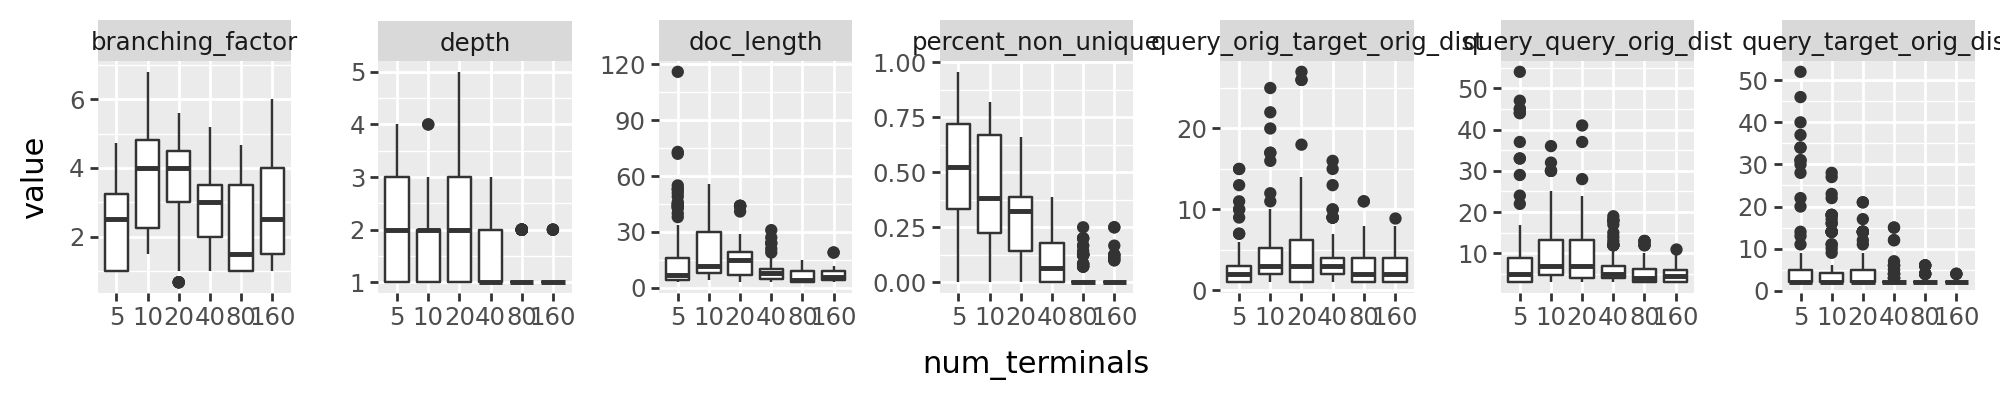

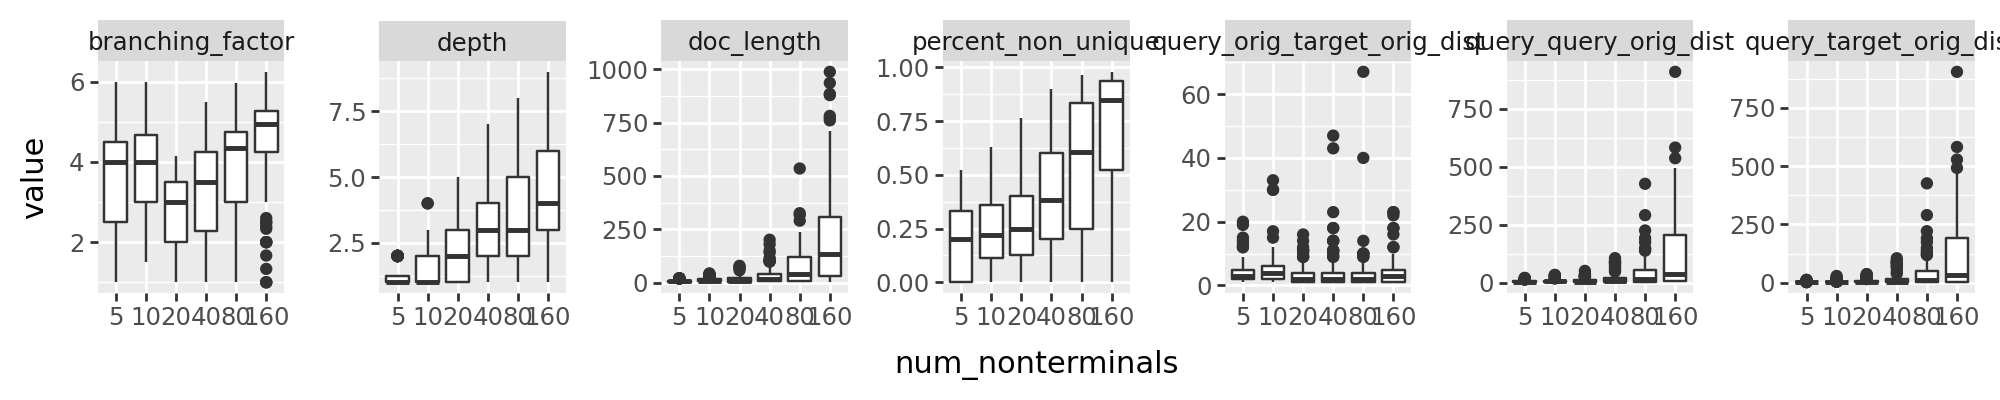

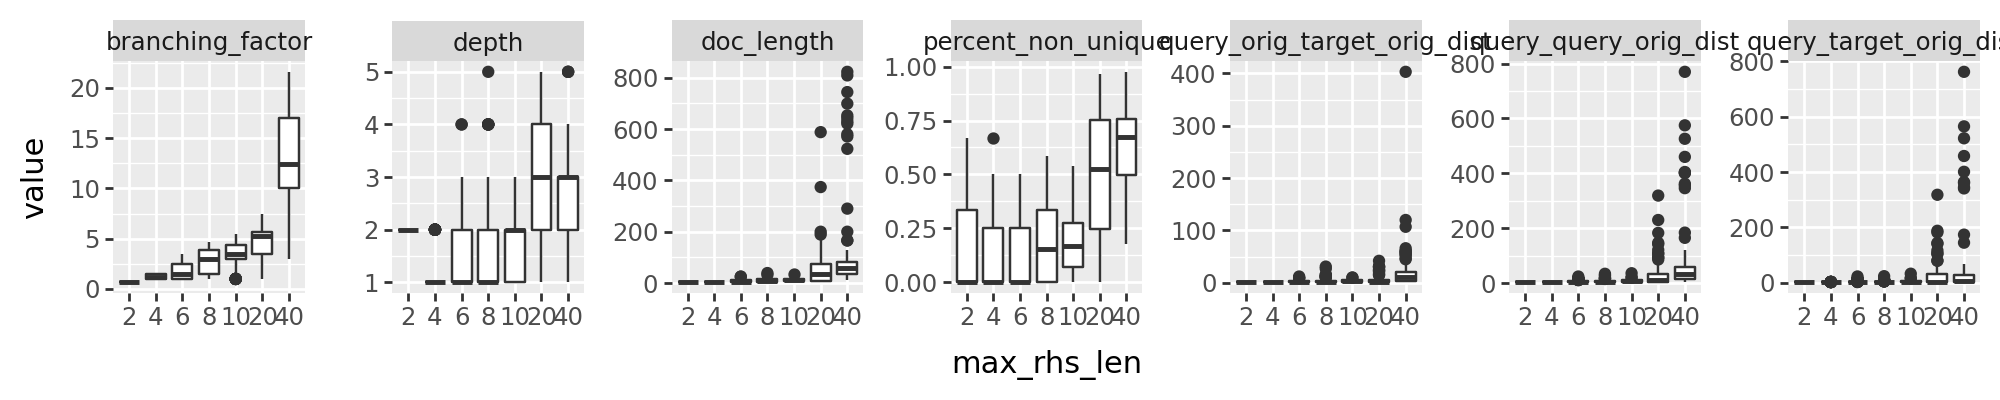

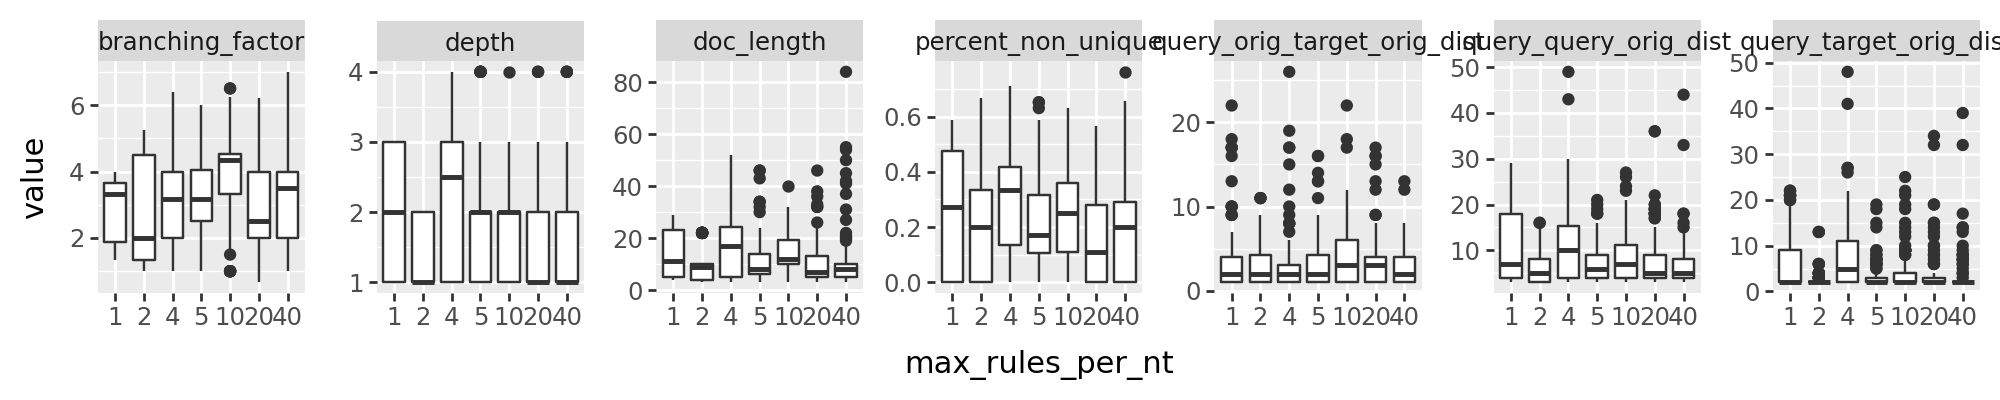

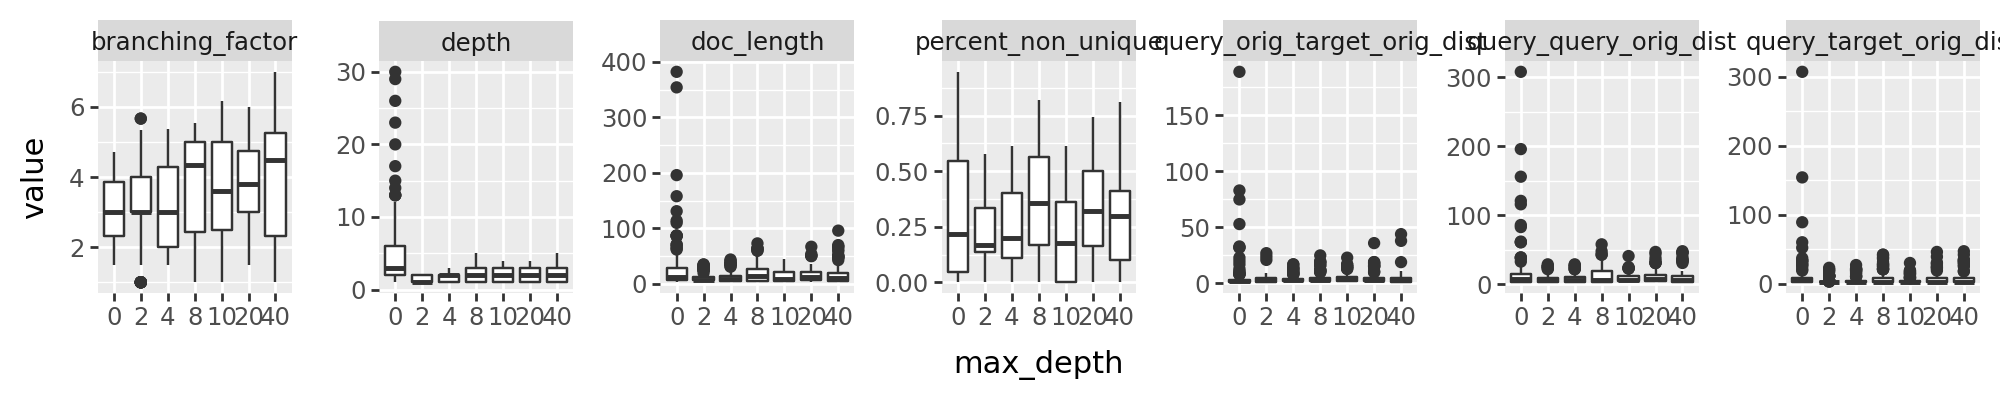

In [4]:
for ablation in ablations:
    metrics = []
    num_samples = 1000
    for ablation_val in ablations[ablation]:
        orig = defaults["config"][ablation]
        defaults["config"][ablation] = ablation_val
        lang = PCFG.from_config(defaults)
        lang.prepare_sets(1, 1, 0, num_samples)
        lang.stats
        for i in range(100):
            for key in lang.stats["test"]:
                if len(lang.stats["test"][key]) != num_samples:
                    continue
                val = lang.stats["test"][key][i]
                metrics.append({
                    "metric": key,
                    "value": val,
                    ablation: ablation_val,
                })
        defaults["config"][ablation] = orig
    
    df = pd.DataFrame(metrics)
    df[ablation] = pd.Categorical(df[ablation])
    plot = (
        p9.ggplot(df, p9.aes(x=ablation, y="value", group=ablation)) + p9.facet_wrap("~metric", nrow=1, scales="free_y") + p9.geom_boxplot() +
        p9.theme(figure_size=(10, 2))
    )
    plot.show()

In [ ]:
df = pd.DataFrame(metrics)
df[a] = pd.Categorical(df[a])
df[b] = pd.Categorical(df[b])
for metric in df["metric"].unique():
    subset_df = df[df["metric"] == metric]
    plot = (
        p9.ggplot(subset_df, p9.aes(x=a, y=b, fill="value")) + p9.geom_tile() + p9.labs(title=metric)
        + p9.geom_text(p9.aes(label="value"))
    )
    plot.show()